In [1]:
#Importing required packages
import torch
import pandas as pd
import numpy as np
import torch.nn as nn
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from math import pi


c:\Program Files\Python310\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Loading data-cleaned up '#' in txt file before reading -> for correct header
df = pd.read_csv("testpattern06_d4.0_R3.0_roving.txt",delim_whitespace=True)
df=df.drop(['#'], axis=1)
df.head()

,Stitch_number_modified,Stitch_path_length,x,y,measured_x1,measured_y1,measured_x2,measured_y2,measured_xm,measured_ym,Deviation_tot,Width,Radius_loc,Radius_locav,Radius_locav2,Radius_locav3
0,1,0.0000,511.3638,-19.0811,510.8245,-17.9730,511.8639,-20.1088,511.3442,-19.0409,0.0447,2.3753,inf,299.8505,17.5033,11.7315
1,1,0.9591,512.3229,-19.0894,511.7820,-18.0891,512.8518,-20.0677,512.3169,-19.0784,0.0125,2.2493,inf,150.5194,15.6020,11.2740
2,1,1.9183,513.2820,-19.0977,512.7094,-18.1517,513.8795,-20.0851,513.2945,-19.1184,0.0242,2.2598,inf,81.0540,13.9990,10.8555
3,1,2.9018,514.2654,-19.1060,513.6625,-18.2269,514.9383,-20.0871,514.3004,-19.1570,0.0618,2.2557,-146.6106,45.6545,12.6165,10.4644
4,1,3.9667,515.3302,-19.1225,514.5880,-18.1910,516.1352,-20.1328,515.3616,-19.1619,0.0504,2.4828,-470.9179,26.2507,11.3705,10.0818


In [3]:
#checking information of dataset
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2155 entries, 0 to 2154
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Stitch_number_modified  2155 non-null   int64  
 1   Stitch_path_length      2155 non-null   float64
 2   x                       2155 non-null   float64
 3   y                       2155 non-null   float64
 4   measured_x1             2155 non-null   float64
 5   measured_y1             2155 non-null   float64
 6   measured_x2             2155 non-null   float64
 7   measured_y2             2155 non-null   float64
 8   measured_xm             2155 non-null   float64
 9   measured_ym             2155 non-null   float64
 10  Deviation_tot           2155 non-null   float64
 11  Width                   2155 non-null   float64
 12  Radius_loc              2155 non-null   float64
 13  Radius_locav            2155 non-null   float64
 14  Radius_locav2           2155 non-null   

In [4]:
#taking the sign of cross product's of x and y values and multiply signs with deviations.
x=df['x'].values
y=df['y'].values
xm=df['measured_xm'].values
ym=df['measured_ym'].values
deviations_values=df['Deviation_tot'].values
xy= np.concatenate((x[:,np.newaxis], y[:,np.newaxis]),axis=1)
xmym=np.concatenate((xm[:,np.newaxis], ym[:,np.newaxis]),axis=1)
dxym=xmym-xy
dxy=xy[1:]-xy[:-1]
dxy=np.concatenate((dxy[0,:][np.newaxis,:],dxy),axis=0)
cross_product= np.cross(dxy,dxym)
deviations=(np.sign(cross_product))*deviations_values
deviations

array([ 0.0447,  0.0125, -0.0242, ...,  0.0189,  0.3096,  0.6669])

In [9]:
#slicing window

def slidingWindow(x, y,  stitchwindow=5):
    x_values = np.lib.stride_tricks.sliding_window_view(x, stitchwindow)
    y_values = np.lib.stride_tricks.sliding_window_view(y, stitchwindow)
    x_values = x_values - x_values[:, stitchwindow // 2][:, np.newaxis]
    y_values = y_values - y_values[:, stitchwindow // 2][:, np.newaxis]
    target = np.lib.stride_tricks.sliding_window_view(deviations, stitchwindow)[:,stitchwindow//2].copy()
    features = np.concatenate((x_values, y_values), axis=1)
    # drop 0 columns:
    features = features[:,[i for i in range(2*stitchwindow) if i!=stitchwindow//2 and i!=(stitchwindow+stitchwindow//2)]].copy()
    ind = np.random.permutation(np.arange(len(features))) # random permutation of dataset
    features = features[ind].copy()
    target = target[ind].copy()[:,np.newaxis]  # fix target shape again
    return features, target, ind  # also return shuffle index
    

In [10]:
# do sliding window arangement:
features, target, sortind =slidingWindow(df['x'].values,df['y'].values, stitchwindow=5)

# resort data for later evaluation with backup data in original order
resort = np.argsort(sortind)
backupfeatures, backuptarget = features[resort,:].copy(), target[resort,:].copy()

# split validation before enrichment -> because data is shuffled we just split after 20% 
fval = 0.2 # take 20% of that data
Nval = int(features.shape[0]*fval)
val_features, val_target = features[:Nval,:].copy(), target[:Nval,:].copy()
features, target = features[Nval:,:].copy(), target[Nval:,:].copy() # now only 80% are used for enrichment

In [12]:
features

array([[-3.7000e-03,  9.9000e-03, -1.0000e-02, ..., -3.9029e+00,
         4.0029e+00,  8.0059e+00],
       [-7.8036e+00, -3.9017e+00,  3.9016e+00, ..., -9.1020e-01,
         1.0103e+00,  2.1204e+00],
       [ 4.1013e+00,  2.5030e+00, -3.3038e+00, ...,  3.0854e+00,
        -2.2861e+00, -3.5727e+00],
       ...,
       [ 5.4782e+00,  2.6890e+00, -2.3888e+00, ...,  3.0049e+00,
        -3.2045e+00, -6.6088e+00],
       [ 8.6737e+00,  4.3560e+00, -4.3559e+00, ...,  6.4000e-03,
        -6.5000e-03, -4.0376e+00],
       [-5.0776e+00, -2.6403e+00,  2.6914e+00, ..., -3.0741e+00,
         2.8947e+00,  5.7894e+00]])

In [13]:
def rotationEnrich(features, target, stitchwindow=5):
    n = stitchwindow
    alpha = np.arange( 0,2*np.pi, 2*np.pi/100)[:, np.newaxis, np.newaxis]
    co, si = np.cos(alpha), np.sin(alpha)
    newfeatures = np.zeros((alpha.shape[0],) + features.shape)
    # shorthand variables:
    nf = newfeatures[:, :, :]
    f = features[np.newaxis, :, :]
    nf[:, :, : (n - 1)] = co * f[:, :, : (n - 1)] - si * f[:, :, (n - 1) :]
    nf[:, :, (n - 1) :] = si * f[:, :, : (n - 1)] + co * f[:, :, (n - 1) :]
    newfeatures = newfeatures.reshape(-1, features.shape[1])
    newtarget = target.reshape(1, -1).repeat(alpha.shape[0], axis=0).ravel()
    
    return newfeatures, newtarget[:,np.newaxis]  # fix target shape again

In [14]:
features,target=rotationEnrich(features, target, stitchwindow=5)

In [15]:
target.shape

(172100, 1)

In [17]:
features

array([[-3.70000000e-03,  9.90000000e-03, -1.00000000e-02, ...,
        -3.90290000e+00,  4.00290000e+00,  8.00590000e+00],
       [-7.80360000e+00, -3.90170000e+00,  3.90160000e+00, ...,
        -9.10200000e-01,  1.01030000e+00,  2.12040000e+00],
       [ 4.10130000e+00,  2.50300000e+00, -3.30380000e+00, ...,
         3.08540000e+00, -2.28610000e+00, -3.57270000e+00],
       ...,
       [ 5.83219038e+00,  2.87237310e+00, -2.58529847e+00, ...,
         2.83012681e+00, -3.04818266e+00, -6.31462077e+00],
       [ 8.65839280e+00,  4.34780629e+00, -4.34771276e+00, ...,
        -2.67128132e-01,  2.67022050e-01, -3.75854721e+00],
       [-5.46016568e+00, -2.82811431e+00,  2.86784885e+00, ...,
        -2.90224816e+00,  2.71999357e+00,  5.43998713e+00]])

In [18]:
# convert to tensors
features=torch.Tensor(features)
target = torch.Tensor(target)
# use small size validation of non enriched data
val_features=torch.Tensor(val_features)
val_target = torch.Tensor(val_target)


In [19]:
#CNN structure
class MyModel(nn.Module):
    def __init__(self, n_features):
        super(MyModel, self).__init__()
        self.layer1 = nn.Linear(n_features, 64)
        self.layer2 = nn.Linear(64, 32)
        self.layer3 = nn.Linear(32, 16)
        self.layer4 = nn.Linear(16,8)
        self.layer5 = nn.Linear(8,1)
    def forward(self, x):
        x = self.layer1(x)
        x = torch.relu(x)
        x = self.layer2(x)
        x = torch.relu(x)
        x = self.layer3(x)
        x = torch.relu(x)
        x = self.layer4(x)
        x = torch.relu(x)
        x = self.layer5(x)
        return x

In [20]:
#compiling the model
model = MyModel(n_features=features.shape[1])
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters())


In [21]:
#Training the models

losses = []
val_losses = []
for epoch in range(3000):

    # Forward pass
    output = model(features)

    # Compute loss
    loss = criterion(output, target)

    # Backward pass and update
    optimizer.zero_grad()
    loss.backward()

    optimizer.step()

 # Print loss
    if epoch % 10 == 0:
        losses.append(float(loss.item()))
        # evaluate validation each time here:
        valloss = criterion(model(val_features), val_target)
        val_losses.append(float(valloss.item()))
        print(f'Epoch {epoch}, Loss: {loss.item()}, validation loss {valloss.item()}')

Epoch 0, Loss: 2.3943369388580322, validation loss 3.064136266708374
Epoch 10, Loss: 2.3712968826293945, validation loss 3.0459280014038086
Epoch 20, Loss: 2.351504325866699, validation loss 3.0277364253997803
Epoch 30, Loss: 2.326975107192993, validation loss 3.0004048347473145
Epoch 40, Loss: 2.285261869430542, validation loss 2.951714038848877
Epoch 50, Loss: 2.2160818576812744, validation loss 2.868799924850464
Epoch 60, Loss: 2.1074533462524414, validation loss 2.7181520462036133
Epoch 70, Loss: 1.9787086248397827, validation loss 2.571843385696411
Epoch 80, Loss: 1.8607455492019653, validation loss 2.5010931491851807
Epoch 90, Loss: 1.7789301872253418, validation loss 2.523585319519043
Epoch 100, Loss: 1.736984133720398, validation loss 2.500828266143799
Epoch 110, Loss: 1.7098525762557983, validation loss 2.466917037963867
Epoch 120, Loss: 1.6881004571914673, validation loss 2.4395644664764404
Epoch 130, Loss: 1.6702178716659546, validation loss 2.408515453338623
Epoch 140, Loss

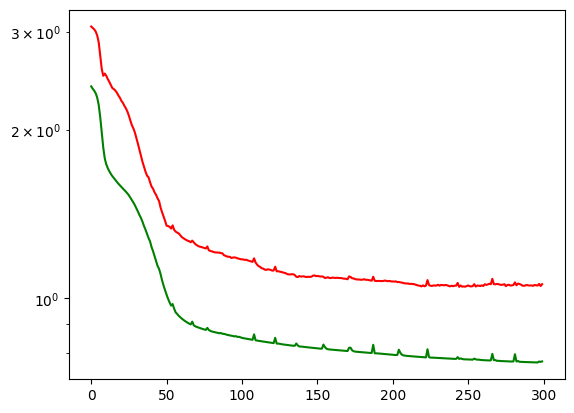

In [27]:
,# plotting the losses in log plot
plt.semilogy(losses,color='green')
plt.semilogy(val_losses,color='red')


In [28]:
#save model, later on we can directly use.
torch.save(model, 'rotation_signed_model.pt')

#we can use model from here  without running epochs
#try printing
#model = torch.load('rotation_signed_model.pt')

### Evaluating the model over the test data

In [29]:
y_pred = model(torch.Tensor(backupfeatures))
print(f"MSE over the model prediction: {mean_absolute_error(backuptarget.tolist(), y_pred.tolist())}")

MSE over the model prediction: 0.24905971245770672


In [30]:
prediction = model(torch.Tensor(backupfeatures))[:,0]
prediction = prediction.detach().numpy().flatten()

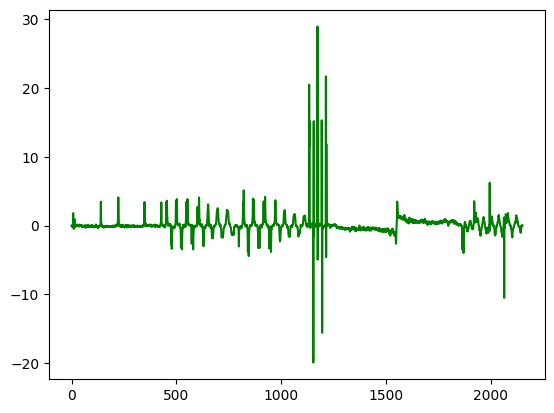

In [34]:
# plot prediction and difference between prediction and actual target

plt.plot(backuptarget.flatten(),color='green')

### Testing over the test data

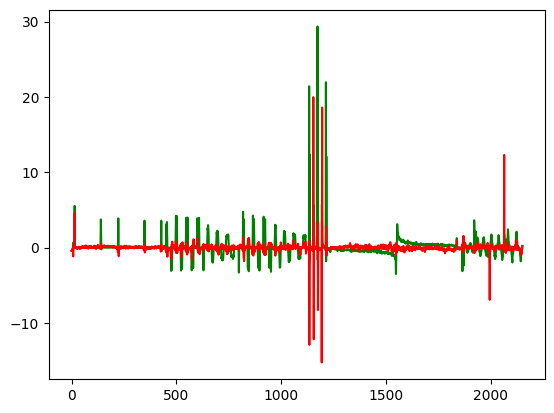

In [35]:

plt.plot(prediction,color='green')
plt.plot(prediction-backuptarget.flatten(),color='red')